<a href="https://colab.research.google.com/github/edgardominguez23/Random-Walks-II/blob/main/TI_1_Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 2

**Nombre:** Dominguez Murillo Edgar Alan

**e-mail:** edgar.dominguez5434@alumnos.udg.mx

## MODULES

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go


from scipy.stats import wrapcauchy
from scipy.stats import levy_stable

## CLASSES

In [3]:
################# http://www.pygame.org/wiki/2DVectorClass ##################
class Vec2d(object):
    """2d vector class, supports vector and scalar operators,
       and also provides a bunch of high level functions
       """
    __slots__ = ['x', 'y']

    def __init__(self, x_or_pair, y = None):
        if y == None:
            self.x = x_or_pair[0]
            self.y = x_or_pair[1]
        else:
            self.x = x_or_pair
            self.y = y

    # Addition
    def __add__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vec2d(self.x + other[0], self.y + other[1])
        else:
            return Vec2d(self.x + other, self.y + other)

    # Subtraction
    def __sub__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x - other.x, self.y - other.y)
        elif (hasattr(other, "__getitem__")):
            return Vec2d(self.x - other[0], self.y - other[1])
        else:
            return Vec2d(self.x - other, self.y - other)

    # Vector length
    def get_length(self):
        return math.sqrt(self.x**2 + self.y**2)

    # rotate vector
    def rotated(self, angle):
        cos = math.cos(angle)
        sin = math.sin(angle)
        x = self.x*cos - self.y*sin
        y = self.x*sin + self.y*cos
        return Vec2d(x, y)

## Actividad 1: Lévy distribution - N Curves (3 pts)

* Generar al menos las 4 curvas de distribución timpo Lévy stable que se observan en la imagen.
* Visualizar con **plotly**.

* Parametros m = 3.0, Levy_exponent = x, beta = 0

In [36]:
# Init variables
m = 3.0
levy_exponents = np.array([0.1, 0.5, 1.0, 1.9])
beta = 0.0

aux_domain = np.linspace(m-5, m+5, 400)

fig_Levy_pdf = go.Figure()

# Generate n stable Lévy distribution curves
for levy_exponent in levy_exponents:
  levy_pdf = np.array([levy_stable.pdf(i, alpha=levy_exponent, beta=beta, loc=m) for i in aux_domain])

  fig_Levy_pdf.add_trace(go.Scatter(x = aux_domain,
                                       y = levy_pdf,
                                       marker = dict(size = 2),
                                       mode = 'lines',
                                       name = 'Levy_{}'.format(levy_exponent),
                                       showlegend = True))

fig_Levy_pdf.show()

## Actividad 2: Lévy distribution - Histogram + Curve (4 pts)

* A partir de un conjunto de valores aleatorios extraidos de una distribución tipo Lévy stable, obtener su histograma y comparar con la curva correspondiente PDF.
* Visualizar con **matplotlib**.

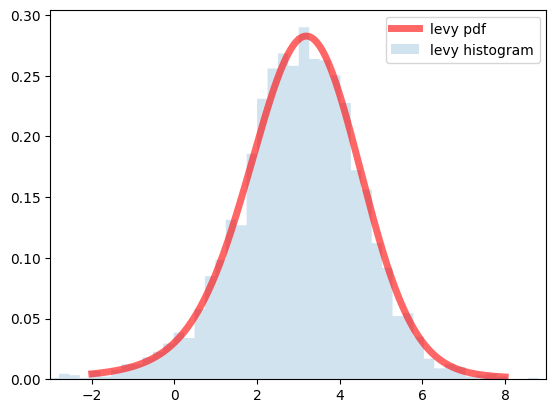

In [35]:
# Init variables
m = 3.0
alpha = 1.8
beta = -0.5
sample_size = 3500

# Create a vector of x values
x = np.linspace(-2, 8, sample_size)

# Create a figure
fig, ax = plt.subplots(1, 1)

# Plot the pdf of the Lévy distribution
ax.plot(x, levy_stable.pdf(x, alpha, beta, loc=m), 'r-', lw=5, alpha=0.6, label='levy pdf')

# Generate random samples from the Lévy distribution
r = levy_stable.rvs(alpha, beta, loc=m, size=sample_size)

# Create a histogram
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='levy histogram')
ax.set_xlim([x[0]-1, x[-1]+1])
ax.legend(loc='best')

#Show histogram + curve
plt.show()


## Actividad 3: Lévy ﬂight - Vec2d - 1 Trajectory (6 pts)

* Utilizar **Vec2d**.
* Guardar trayectorias en **Pandas** Data Frame.
* Visualizar proyección en 3d con **plotly**.

In [91]:
# Init variables
n_steps = 1000
time_per_step = 0.0001
s_pos = [0,0,0]
speed = 10
max_step_length = 10.0

std_motion_steps = 5.0
levy_exponent = 0.2
beta = 0.0

positions = [{'x': s_pos[0], 'y':s_pos[1], 'z':s_pos[2]}]

# Init velocity vector
velocity = Vec2d(speed, 0)

angles = levy_stable.rvs(levy_exponent, beta, loc=std_motion_steps, size=n_steps-1)

for i in range(n_steps-1):
  turn_angle = angles[i]

  # Generate a step length according to the Lévy distribution
  step_length = levy_stable.rvs(alpha, beta)
  step_length = min(step_length, max_step_length)

  velocity = velocity.rotated(turn_angle)

  # Calculate distance traveled in this step
  distance_traveled = velocity.get_length() * time_per_step * step_length

  new_position = {
      'x': positions[-1]['x'] + velocity.x * step_length,
      'y': positions[-1]['y'] + velocity.y * step_length,
      'z': positions[-1]['z'] + distance_traveled
  }

  positions.append(new_position)

# Convert list of positions to DataFrame
levy_3d_pdf = pd.DataFrame(positions)

# 3D projection
fig = go.Figure(
    data=[
      go.Scatter3d(
          x = levy_3d_pdf.z,
          y = levy_3d_pdf.x,
          z = levy_3d_pdf.y,
          mode = 'lines',
          name = 'Levy Flight 3D',
          showlegend = True
      )
    ]
)

fig.update_layout(
    scene=dict(
        xaxis=dict(title='time'),
        yaxis=dict(title='x_pos (mm)'),
        zaxis=dict(title='y_pos (mm)')
    ),
    title='Levy Flight in 3D',
)
fig.show()


## Actividad 4: Correlated Random Walk - Vec2d - N Trajectories (7 pts)

* Generar tantas trayectorias tipo CRW como se especifique en una variable **n_traj**.
* Cada una de las trayectorias debera tener un coeficiente de Cauchy diferente.
* Utilizar **Vec2d**.
* Guardar trayectorias en **Pandas** Data Frame.
* Visualizar proyección en 3d con **plotly**.
* Exportar el Data Frame con las trayectorias a un archivo tipo *pkl*.

In [47]:
# Init parameters
crw_coefficients = [0.2, 0.35, 0.5, 0.65, 0.8, 0.95]

n_steps = 10000
time_per_step = 0.00001
s_pos = 0
speed = 10
resolution = 200

trajectories = []
data = []

for crw_exponent in crw_coefficients:
  # Init velocity vector
  velocity = Vec2d(speed,0)
  initial_positions = np.ones(shape=(n_steps,3))*s_pos

  aux_domain = np.linspace(0, 2*np.pi, resolution)
  wrapcauchy_pdf = np.array([wrapcauchy.pdf(i, crw_exponent) for i in aux_domain])
  wrapcauchy_pdf /= np.sum(wrapcauchy_pdf)

  for j in range(1,n_steps):
    # Choose the angle of rotation
    turn_angle = np.random.choice(aux_domain, p=wrapcauchy_pdf)
    velocity = velocity.rotated(turn_angle)

    # Update location
    initial_positions[j,0] = initial_positions[j-1,0]+velocity.x
    initial_positions[j,1] = initial_positions[j-1,1]+velocity.y

    # Calculate distance traveled in this step
    distance_traveled = velocity.get_length() * time_per_step

    # Accumulate time
    initial_positions[j,2] = initial_positions[j-1,2]+distance_traveled

  trajectories.append(initial_positions)

crw_trajectories = trajectories

for index, crw_trajectory in enumerate(crw_trajectories):
  data.append(
      go.Scatter3d(x=crw_trajectory[:, 0], y=crw_trajectory[:, 1], z=crw_trajectory[:, 2], mode='lines', name='CRW, Cauchy {}'.format(crw_coefficients[index]))
  )

# 3D projection
fig = go.Figure(data=data)
fig.update_layout(
    scene=dict(
        xaxis=dict(title='x_pos (mm)'),
        yaxis=dict(title='y_pos (mm)'),
        zaxis=dict(title='time')
    ),
    title='CRW trajectory in 3D'
)
fig.show()